# MILVUS DEMO

# Image Similarity Search with Milvus in watsonx.data

## Disclaimers
- Use only Projects and Spaces that are available in watsonx context.

## Notebook Overview
This notebook demonstrates text similarity search support in watsonx.data, introducing commands for:
- Connecting to Milvus
- Creating collections
- Creating indexes
- Ingesting data
- Data retrieval

**Note**: Some familiarity with Python is helpful. This notebook uses Python 3.11.

## About Milvus

Milvus is an open-source vector database designed specifically for scalable similarity search and AI applications. It's a powerful platform that enables efficient storage, indexing, and retrieval of vector embeddings, which are crucial in modern machine learning and artificial intelligence tasks.

### Milvus: Three Fundamental Steps

#### 1. Data Preparation
Collect and convert your data into high-dimensional vector embeddings. These vectors are typically generated using machine learning models like neural networks, which transform text, images, audio, or other data types into dense numerical representations that capture semantic meaning and relationships.

#### 2. Vector Insertion
Load the vector embeddings into Milvus collections or partitions within a database. Milvus creates indexes to optimize subsequent search operations, supporting various indexing algorithms like IVF-FLAT, HNSW, etc., based on the definition.

#### 3. Similarity Search
Perform vector similarity searches by providing a query vector. Milvus will rapidly return the most similar vectors from the collection or partitions based on the defined metrics like cosine similarity, Euclidean distance, or inner product.

## Key Workflow

1. **Definition** (once)
2. **Ingestion** (once)
3. **Retrieve relevant passage(s)** (for every user query)

## Notebook Contents

- Environment Setup
- Install packages
- Document data loading
- Create connection
- Ingest data
- Retrieve relevant data

## Environment Setup

Before using the sample code in this notebook, complete the following setup tasks:

- Create a Watsonx.data instance (a free plan is offered)
  - Information about creating a watsonx.data instance can be found [here](https://www.ibm.com/docs/en/watsonx/watsonxdata/2.0.x)



### Import Libraries

In [1]:
!pip install matplotlib

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import ssl
from pymilvus import connections

In [3]:
!pip show pymilvus

Name: pymilvus
Version: 2.4.0
Summary: Python Sdk for Milvus
Home-page: None
Author: None
Author-email: Milvus Team <milvus-team@zilliz.com>
License: None
Location: /usr/local/lib/python3.10/dist-packages
Requires: pyarrow, scipy, minio, grpcio, requests, environs, azure-storage-blob, pandas, ujson, setuptools, protobuf
Required-by: 


In [4]:
!pip install torch torchvision

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
import torch

# Load the embedding model with the last layer removed
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Load Data

In [7]:
FOLDER = "animals"
#PATH = "/root/demo/image-similarity/data"
#OUTPUT_PATH = "/root/demo/image-similarity/data/results"
COLLECTION_NAME = FOLDER
DIMENSION = 2048

In [8]:
import glob

paths = glob.glob(f'../data/{FOLDER}/*.png')
print(len(paths))


26


### Connect to Milvus

In [4]:
from pymilvus import Collection, FieldSchema, CollectionSchema, DataType,connections

In [1]:
# Replace Placeholder Values <> with respective provisioned Milvus Values .

In [5]:
# On Prem
connections.connect(
            alias='default',
            host="<Milvus GRPC host On CPD>",
            port=443,
            secure=True,
            server_pem_path="<GRPC certificate path>",
            server_name="<Milvus GRPC host On CPD>",
            user="<user>",
            password="<password>")

In [9]:
# SaaS
connections.connect(
            alias='default',
            host="<Milvus GRPC host On SaaS>",
            port="<Milvus GRPC port On SaaS>",
            secure=True,
            user="<user>",
            password="<password>")

In [10]:
from pymilvus import utility

if utility.has_collection(COLLECTION_NAME):
    reply = input(f"Drop collection {COLLECTION_NAME}? [y/N]: ")
    if reply.lower() in ["y", "yes"]:
        utility.drop_collection(COLLECTION_NAME)
else:
    print(f"Collection {COLLECTION_NAME} doesn't exist, skip drop")

Drop collection animals? [y/N]:  y


In [11]:


fields = [
    FieldSchema(name='id', dtype=DataType.INT64, auto_id=True, is_primary=True),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
]
schema = CollectionSchema(fields)
collection = Collection(COLLECTION_NAME, schema)

In [12]:
index_params = {
    'metric_type': 'L2',
    'index_type': "IVF_FLAT",
    'params': {'nlist': 16384}
}
collection.create_index(field_name="embedding", index_params=index_params)
collection.load()

In [13]:
#!pip install --upgrade torch torchvision

from torchvision import transforms
# Preprocessing for images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [14]:
from PIL import Image
from tqdm import tqdm

BATCH_SIZE = 128

# Embed function that embeds the batch and inserts it
def embed(data):
    with torch.no_grad():
        output = model(torch.stack(data[0])).squeeze()
        collection.insert([data[1], output.tolist()])

data_batch = [[],[]]

# Read the images into batches for embedding and insertion
for path in tqdm(paths):
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)
    if len(data_batch[0]) % BATCH_SIZE == 0:
        embed(data_batch)
        data_batch = [[],[]]

# Embed and insert the remainder
if len(data_batch[0]) != 0:
    embed(data_batch)

# Call a flush to index any unsealed segments.
collection.flush()

100%|███████████████████████████████████████████████████| 26/26 [00:00<00:00, 73.17it/s]


You can either create your own dataset tailored to your specific needs or source one from reputable online repositories.

In [17]:
import glob

search_paths = glob.glob(f'../data/test_{FOLDER}/*.png')
print(len(search_paths))


3


In [18]:
import time
from matplotlib import pyplot as plt
from PIL import Image

TOP_K = 3

# Embed the search images
def embed(data):
    with torch.no_grad():
        ret = model(torch.stack(data))
        # If more than one image, use squeeze
        if len(ret) > 1:
            return ret.squeeze().tolist()
        # Squeeze would remove batch for single image, so using flatten
        else:
            return torch.flatten(ret, start_dim=1).tolist()

data_batch = [[],[]]

for path in search_paths:
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)

embeds = embed(data_batch[0])
start = time.time()
res = collection.search(embeds, anns_field='embedding', param={'nprobe': 128}, limit=TOP_K, output_fields=['filepath'])
finish = time.time()

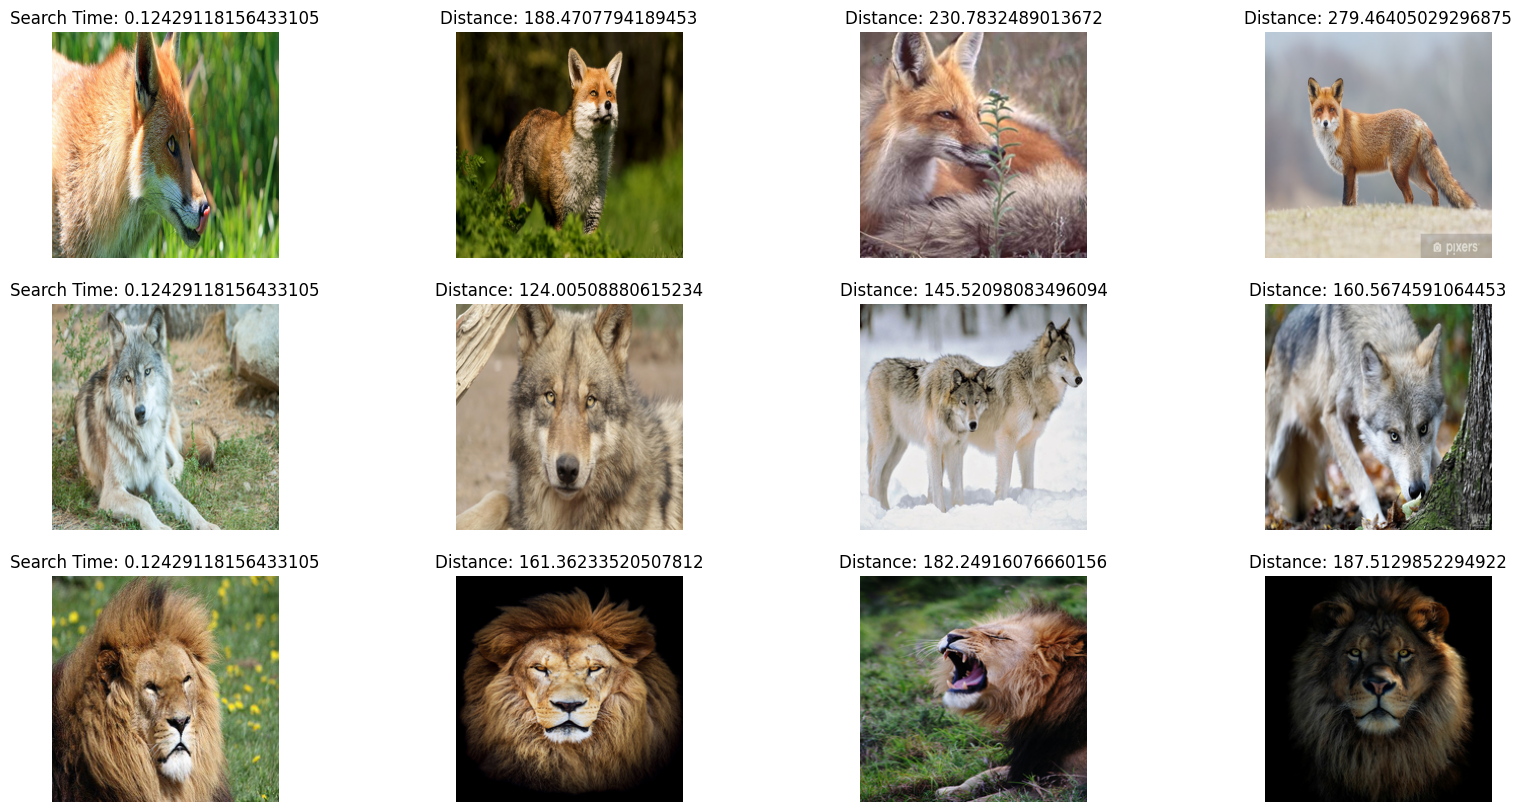

In [21]:
# Show the image results
f, axarr = plt.subplots(len(data_batch[1]), TOP_K + 1, figsize=(20, 10), squeeze=False)

for hits_i, hits in enumerate(res):
    axarr[hits_i][0].imshow(Image.open(data_batch[1][hits_i]))
    axarr[hits_i][0].set_axis_off()
    axarr[hits_i][0].set_title('Search Time: ' + str(finish - start))
    for hit_i, hit in enumerate(hits):
        axarr[hits_i][hit_i + 1].imshow(Image.open(hit.entity.get('filepath')))
        axarr[hits_i][hit_i + 1].set_axis_off()
        axarr[hits_i][hit_i + 1].set_title('Distance: ' + str(hit.distance))

# Save the search result in a separate image file alongside your script.
plt.savefig(f'../search_result_{FOLDER}.png')